In [3]:
from tensorflow import keras
from utils.classification import train_classifier
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from utils.images import resample_img, normalize
from skimage.transform import resize
from random import shuffle
from tensorflow.keras.utils import to_categorical
from utils.plot_methods import plot_clf_history


In [2]:
from utils.classification import model
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SpatialDropout2D
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np

In [177]:
# Load data
img_40 = sitk.ReadImage('./data/common_40_image.nii.gz', sitk.sitkFloat32)
img_41 = sitk.ReadImage('./data/common_41_image.nii.gz', sitk.sitkFloat32)
img_42 = sitk.ReadImage('./data/common_42_image.nii.gz', sitk.sitkFloat32)
img_53 = sitk.ReadImage('./data/g1_53_image.nii.gz', sitk.sitkFloat32)
img_54 = sitk.ReadImage('./data/g1_54_image.nii.gz', sitk.sitkFloat32)
img_55 = sitk.ReadImage('./data/g1_55_image.nii.gz', sitk.sitkFloat32)

# img_40 = sitk.GetArrayFromImage(resample_img(normalize(img_40), out_size= [512,512,256]))
# img_41 = sitk.GetArrayFromImage(resample_img(normalize(img_41), out_size= [512,512,256]))
# img_42 = sitk.GetArrayFromImage(resample_img(normalize(img_42), out_size= [512,512,256]))

# img_53 = sitk.GetArrayFromImage(resample_img(normalize(img_53), out_size= [512,512,256]))
# img_54 = sitk.GetArrayFromImage(resample_img(normalize(img_54), out_size= [512,512,256]))
# img_55 = sitk.GetArrayFromImage(resample_img(normalize(img_55), out_size= [512,512,256]))

img_40 = sitk.GetArrayFromImage(resample_img(img_40, out_size= [512,512,256]))
img_41 = sitk.GetArrayFromImage(resample_img(img_41, out_size= [512,512,256]))
img_42 = sitk.GetArrayFromImage(resample_img(img_42, out_size= [512,512,256]))

img_53 = sitk.GetArrayFromImage(resample_img(img_53, out_size= [512,512,256]))
img_54 = sitk.GetArrayFromImage(resample_img(img_54, out_size= [512,512,256]))
img_55 = sitk.GetArrayFromImage(resample_img(img_55, out_size= [512,512,256]))

In [181]:
# Generate training data
x_train = []
# imgs = [img_53, img_54, img_55]
imgs = [img_53]

for img in imgs:
    for idx in range(512):
        slice = img[:,:,idx]
        x_train.append(slice)

# Generate validation data
x_val = []
for idx in range(512):
    slice = img_40[:,:,idx]
    x_val.append(slice)

x_train = np.array(x_train)
x_val = np.array(x_val)


In [182]:
# Generate ground truth for training data
y_53 = np.zeros(512)
y_53[173:212] = 1
y_53[312:345] = 1

y_54 = np.zeros(512)
y_54[160:203] = 1
y_54[290:326] = 1

y_55 = np.zeros(512)
y_55[181:225] = 1
y_55[292:331] = 1

# Validation data
y_40 = np.zeros(512)
y_40[161:199] = 1
y_40[298:331] = 1

In [183]:
# y_train = np.concatenate((y_53, y_54, y_55),axis=0)

# y_train = to_categorical(y_train)
y_train = to_categorical(y_53)

y_val = to_categorical(y_40)

In [168]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
def generator(x_train, y_train, batch_size):
    while True:
               
        for ind in (range(0, len(x_train), batch_size)):
            
            batch_img = x_train[ind:ind+batch_size]
            batch_label = y_train[ind:ind+batch_size]
            
            # Sanity check assures batch size always satisfied
            # by repeating the last 2-3 images at last batch.
            if len(batch_img) == batch_size:
                pass
            else:
                for tmp in range(batch_size - len(batch_img)):
                    batch_img = np.append(batch_img, np.expand_dims(batch_img[-1],axis=0), axis = 0)
                    batch_label = np.append(batch_label, np.expand_dims(batch_label[-1], axis=0), axis = 0)
        
            backgound_value = x_train.min()
            data_gen_args = dict(rotation_range=10.,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     cval = backgound_value,
                                     zoom_range=0.2,
                                     horizontal_flip = True)
            
            image_datagen = ImageDataGenerator(**data_gen_args)
            label_datagen = ImageDataGenerator()
            
            image_generator = image_datagen.flow(batch_img, shuffle=False,
                                                 batch_size=batch_size,
                                                 seed=1)
            
            label_generator = label_datagen.flow(batch_label, shuffle=False,
                                               batch_size=batch_size,
                                               seed=1)
            
            image = image_generator.next()
            label = label_generator.next()
            
            
            yield (image, label)

In [49]:
import random
c = list(zip(x_train,y_train))
random.shuffle(c)
x_train, y_train = zip(*c)
x_train = np.array(x_train)
y_train = np.array(y_train)

In [42]:
len(y_train[:,1])/len(np.where(y_train[:,1]==1)[0])

6.564102564102564

## Machine learning methdos

In [84]:
## reshape x
X = x_train.reshape((x_train.shape[0],x_train.shape[1] * x_train.shape[2] ))
scaler = StandardScaler().fit(X)

In [85]:
X = scaler.transform(X)

In [87]:
class_weight = {0.: 1.,
                1.: 7}

In [88]:
np.unique(y_train)

array([0., 1.])

In [89]:
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
clf = svm.SVC(probability=True,kernel='rbf',class_weight= class_weight, random_state=1536)
clf.fit(X, y_train)

SVC(class_weight={0.0: 1.0, 1.0: 7}, probability=True, random_state=1536)

In [81]:
X_val = x_val.reshape((x_val.shape[0],x_val.shape[1] * x_val.shape[2] ))

In [49]:
scaler_2 = StandardScaler().fit(X_val)
X_val = scaler_2.transform(X_val)

In [42]:
clf.score(X_val, y_40)

0.861328125

In [198]:
import numpy as np
import SimpleITK as sitk

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

#AlexNet from Lab3 Task2
def AlexNet(img_ch, img_width, img_height, n_base=8, dropout=True, batch_norm=True):

    """
    This function is used to resample the input image mask with the given size.

    Parameters
    ----------
    img_ch : 
        The number of image chanels
    img_width :
        Image width
    img_height :
        Image height
    n_base :
        Number of neurons in the first convolution layer
    dropout : True or False
        Include dropout layers
    batch_norm : True or False
        Include batch normalization layers

    Returns
    -----------
    The model ready for the training.

    """

    model = Sequential()

    model.add(Conv2D(filters=n_base, input_shape=(img_width, img_height, img_ch),
    kernel_size=(3,3), strides=(1,1), padding='same'))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
   
    model.add(Conv2D(filters= n_base *2, kernel_size=(3,3), strides=(1,1), padding='same'))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters= n_base *4, kernel_size=(3,3), strides=(1,1), padding='same'))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(filters= n_base *4, kernel_size=(3,3), strides=(1,1), padding='same'))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(filters= n_base *2, kernel_size=(3,3), strides=(1,1), padding='same', name = 'Last_ConvLayer'))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(128))
    if dropout:
        model.add(Dropout(0.4))
    model.add(Activation('relu'))
    model.add(Dense(64))
    if dropout:
        model.add(Dropout(0.4))
    model.add(Activation('relu'))

    model.add(Dense(2))
    model.add(Activation('softmax'))
    model.summary()
    
    return model


In [199]:
model = AlexNet(1,256,512,8,True,True)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 256, 512, 8)       80        
                                                                 
 batch_normalization_25 (Bat  (None, 256, 512, 8)      32        
 chNormalization)                                                
                                                                 
 activation_40 (Activation)  (None, 256, 512, 8)       0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 128, 256, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 128, 256, 16)      1168      
                                                                 
 batch_normalization_26 (Bat  (None, 128, 256, 16)    

In [202]:
model.compile(loss = 'categorical_crossentropy',         
            optimizer = Adam(lr = 1e-6),
            metrics = ['accuracy'])

In [205]:
batch_size = 8
class_weight = {0: 1.,
                1: 6}
history = model.fit(x_train, y_train, 
                    batch_size = batch_size,
                    validation_data = (x_val, y_val),
                    class_weight = class_weight,
                    epochs = 40, verbose=1)

Epoch 1/40
64/64 [==============================] - 38s 585ms/step - loss: 0.1733 - accuracy: 0.9668 - val_loss: 0.6721 - val_accuracy: 0.8613
Epoch 2/40
64/64 [==============================] - 35s 540ms/step - loss: 0.1534 - accuracy: 0.9668 - val_loss: 0.7012 - val_accuracy: 0.8613
Epoch 3/40
64/64 [==============================] - 35s 542ms/step - loss: 0.1328 - accuracy: 0.9785 - val_loss: 0.6697 - val_accuracy: 0.8613
Epoch 4/40
64/64 [==============================] - 37s 585ms/step - loss: 0.1191 - accuracy: 0.9785 - val_loss: 0.7048 - val_accuracy: 0.8613
Epoch 5/40
64/64 [==============================] - 39s 614ms/step - loss: 0.1252 - accuracy: 0.9727 - val_loss: 0.7639 - val_accuracy: 0.8613
Epoch 6/40
64/64 [==============================] - 41s 646ms/step - loss: 0.1462 - accuracy: 0.9727 - val_loss: 0.7305 - val_accuracy: 0.8613
Epoch 7/40
11/64 [====>.........................] - ETA: 28s - loss: 0.1202 - accuracy: 0.9886

KeyboardInterrupt: 

In [188]:
x_val = []
for idx in range(512):
    slice = img_42[:,:,idx]
    x_val.append(slice)
x_val = np.array(x_val)

In [189]:
y_pred = model.predict(x_val)

In [190]:
np.where(y_pred[:,1] == y_pred[:,1].max())

(array([309]),)

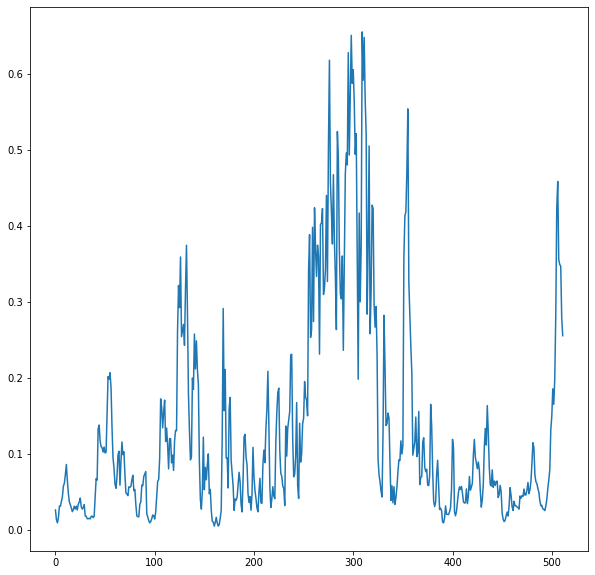

In [191]:
y_pred[:,1]
plt.figure(1, figsize = (10,10))
plt.plot(y_pred[:,1])
# plt.plot(y_val[:,1])

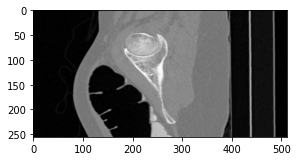

In [167]:
plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(x_val[122], cmap = "Greys_r")

## Deep learning methods

In [102]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
model = models.Sequential()
# model.add(layers.Rescaling(1./255, input_shape=(256, 512, 1)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 512, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 510, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 255, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 253, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 126, 64)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 124, 64)       36928     
                                                                 
 flatten_2 (Flatten)         (None, 476160)           

In [103]:
model.compile(loss = 'categorical_crossentropy',         
            optimizer = Adam(lr = 1e-6),
            metrics = ['accuracy'])

/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [104]:
batch_size = 8
class_weight = {0: 1.,
                1: 7}
history = model.fit(x_train, y_train, 
                    batch_size = batch_size,
                    validation_data = (x_val, y_val),
                    class_weight = class_weight,
                    epochs = 1, verbose=1)

192/192 [==============================] - 145s 750ms/step - loss: 9.0225 - accuracy: 0.8281 - val_loss: 10.5653 - val_accuracy: 0.8613


In [105]:
y_pred = model.predict(x_val)

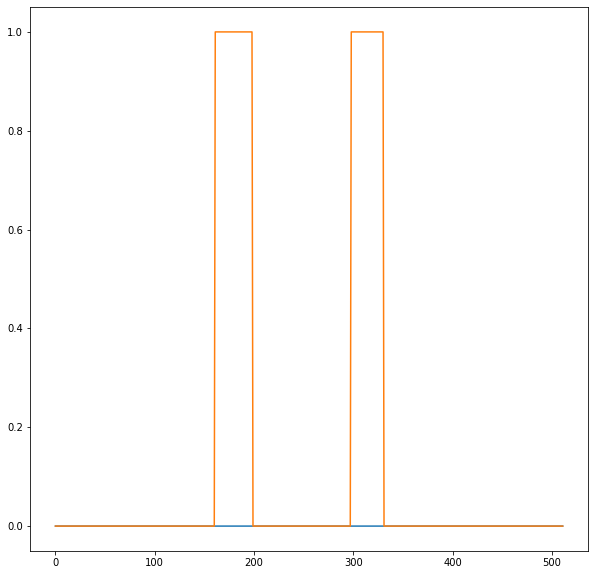

In [106]:
y_pred[:,1]
plt.figure(1, figsize = (10,10))
plt.plot(y_pred[:,1])
plt.plot(y_val[:,1])

In [158]:
image_shape = (256,512,1)
X_train = x_train.reshape(x_train.shape[0],*image_shape)
X_train.shape


(1536, 256, 512, 1)

In [163]:
model.fit(X_train, y_train, epochs=10, batch_size=50, verbose=1, validation_split=0.2)

Epoch 1/10


ValueError: in user code:

    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/losses.py", line 1789, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/backend.py", line 5083, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 2) and (None, 256, 2) are incompatible


In [8]:
def model_tt(img_ch, img_width, img_height, n_base):
    
    model = Sequential()
    model.add(Conv2D(filters=n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(filters=n_base*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # model.add(Conv2D(filters=n_base*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    # model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    model.add(Dense(2))
    model.add(Activation('softmax'))

    model.summary()   
    return model

In [69]:
# import necessary layers  
from tensorflow.keras.layers import Input, Conv2D 
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense 
from tensorflow.keras import Model
# input

input = Input(shape =(256,512,1))
# 1st Conv Block

x = Conv2D (filters =8, kernel_size =3, padding ='same', activation='relu')(input)
x = Conv2D (filters =8, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# # 2nd Conv Block

x = Conv2D (filters =16, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =16, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# # 3rd Conv block

# x = Conv2D (filters =32, kernel_size =3, padding ='same', activation='relu')(x)
# x = Conv2D (filters =32, kernel_size =3, padding ='same', activation='relu')(x)
# x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# # 4th Conv block

x = Conv2D (filters =16, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =16, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# # 5th Conv block

x = Conv2D (filters =8, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =8, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# Fully connected layers

x = Flatten()(x)
x = Dense(units = 64, activation ='relu')(x)
x = Dropout(0.2)(x)
x = Dense(units = 32, activation ='relu')(x)
x = Dropout(0.2)(x)
output = Dense(units = 2, activation ='softmax')(x)
# creating the model

new_model = Model (inputs=input, outputs =output)
new_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256, 512, 1)]     0         
                                                                 
 conv2d_69 (Conv2D)          (None, 256, 512, 8)       80        
                                                                 
 conv2d_70 (Conv2D)          (None, 256, 512, 8)       584       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 128, 256, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None, 128, 256, 16)      1168      
                                                                 
 conv2d_72 (Conv2D)          (None, 128, 256, 16)      2320      
                                                           

In [70]:
batch_size = 16
n_base = 8
learning_rate = 1e-6
n_epochs = 30
new_model.compile(loss = 'categorical_crossentropy',         
            optimizer = Adam(lr = learning_rate),
            metrics = ['accuracy'])
class_weight = {0: 1.,
                1: 10}

In [71]:
history = new_model.fit(x_train, y_train, 
                    batch_size = batch_size,
                    validation_data = (x_val, y_val),
                    class_weight = class_weight,
                    epochs = n_epochs, verbose=1)

Epoch 1/30
96/96 [==============================] - 103s 1s/step - loss: 1.9649 - accuracy: 0.5150 - val_loss: 0.6557 - val_accuracy: 0.6191
Epoch 2/30
96/96 [==============================] - 98s 1s/step - loss: 1.7157 - accuracy: 0.4648 - val_loss: 0.7025 - val_accuracy: 0.5000
Epoch 3/30
68/96 [====================>.........] - ETA: 25s - loss: 1.7131 - accuracy: 0.4531

KeyboardInterrupt: 

In [20]:
from utils.classification import model
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SpatialDropout2D
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np

batch_size = 8
n_base = 8
learning_rate = 5e-7
MLP = model_tt(1, 256, 512, n_base)
MLP.compile(loss = 'categorical_crossentropy',         
            optimizer = Adam(lr = learning_rate),
            metrics = ['accuracy'])
class_weight = {0: 1.,
                1: 10}
n_epochs = 10
history = MLP.fit(x_train, y_train, 
                    batch_size = batch_size,
                    validation_data = (x_val, y_val),
                    class_weight = class_weight,
                    epochs = n_epochs, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 256, 512, 8)       80        
                                                                 
 batch_normalization (BatchN  (None, 256, 512, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 512, 8)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 512, 16)      1168      
                                                                 
 activation_1 (Activation)   (None, 256, 512, 16)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 256, 16)     0         
 2D)                                                    

/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


192/192 [==============================] - 189s 981ms/step - loss: 1.2846 - accuracy: 0.5801 - val_loss: 0.4049 - val_accuracy: 0.8613
Epoch 2/10
192/192 [==============================] - 194s 1s/step - loss: 0.7225 - accuracy: 0.7988 - val_loss: 0.4470 - val_accuracy: 0.8613
Epoch 3/10
192/192 [==============================] - 199s 1s/step - loss: 0.5218 - accuracy: 0.8620 - val_loss: 0.5401 - val_accuracy: 0.8613
Epoch 4/10
192/192 [==============================] - 191s 997ms/step - loss: 0.3950 - accuracy: 0.8978 - val_loss: 0.6415 - val_accuracy: 0.8613
Epoch 5/10
192/192 [==============================] - 191s 994ms/step - loss: 0.3601 - accuracy: 0.9095 - val_loss: 0.7441 - val_accuracy: 0.8613
Epoch 6/10
192/192 [==============================] - 242s 1s/step - loss: 0.2762 - accuracy: 0.9368 - val_loss: 0.8010 - val_accuracy: 0.8613
Epoch 7/10
192/192 [==============================] - 210s 1s/step - loss: 0.2706 - accuracy: 0.9453 - val_loss: 0.8180 - val_accuracy: 0.8613
E

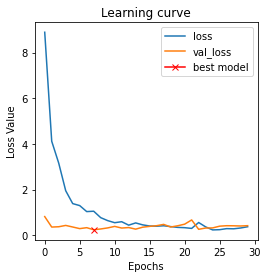

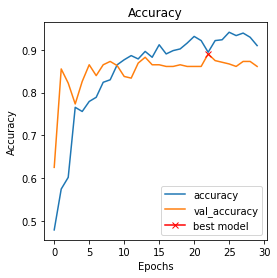

In [14]:
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]),
        np.min(history.history["val_loss"]),
        marker="x", color="r", label="best model")

plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend()
plt.show()

plt.figure(figsize=(4, 4))
plt.title("Accuracy")
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmax(history.history["val_accuracy"]),
        np.max(history.history["val_accuracy"]),
        marker="x", color="r", label="best model")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [15]:
y_pred = new_model.predict(x_val)

In [16]:
y_pred[:,1].max()

0.45935422

In [17]:
np.where(y_pred[:,1] == y_pred[:,1].max())

(array([191]),)

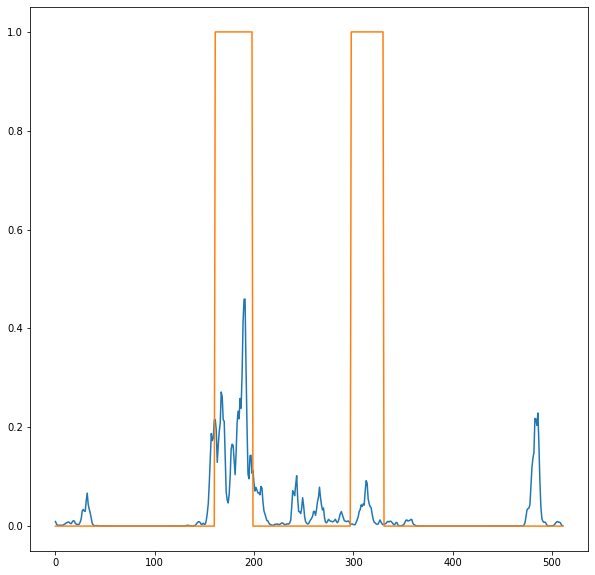

In [18]:
y_pred[:,1]
plt.figure(1, figsize = (10,10))
plt.plot(y_pred[:,1])
plt.plot(y_val[:,1])

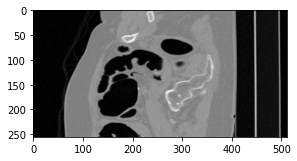

In [20]:
plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(x_val[191], cmap = "Greys_r")

In [24]:
x_test = []
for idx in range(512):
    slice = img_41[:,:,idx]
    x_test.append(slice)
x_test = np.array(x_test)

0.6330658
(array([511]),)


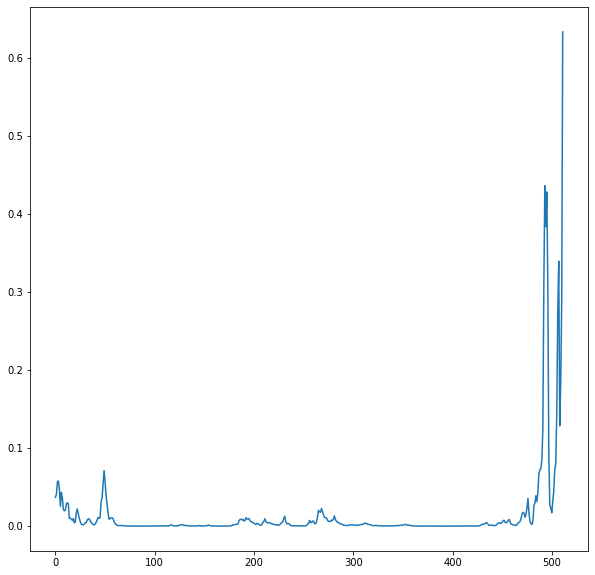

In [25]:
y_pred = new_model.predict(x_test)
print(y_pred[:,1].max())
print(np.where(y_pred[:,1] == y_pred[:,1].max()))
y_pred[:,1]
plt.figure(1, figsize = (10,10))
plt.plot(y_pred[:,1])


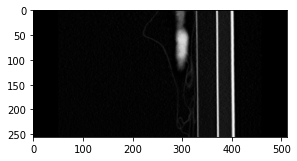

In [27]:
plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(x_test[511], cmap = "Greys_r")

In [62]:
import sklearn
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [66]:
nsamples, nx, ny = x_train.shape
X = x_train.reshape((nsamples,nx*ny))

Y = y_train


In [67]:
model = SVC(probability=True,kernel='rbf',random_state=615)
scores = cross_val_score(model,X,Y,cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
model.fit(X,Y)

0.85 accuracy with a standard deviation of 0.00


SVC(probability=True, random_state=615)

In [69]:
x_test = x_test.reshape((x_test.shape[0],x_test.shape[1] * x_test.shape[2]))

In [74]:
y_pred = model.predict(x_test)

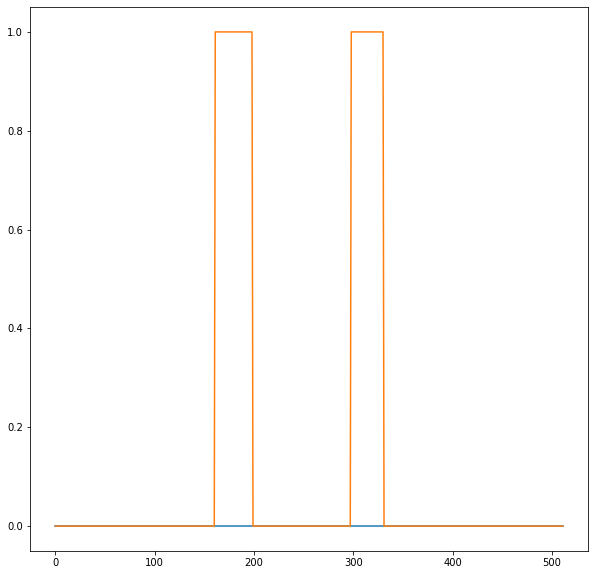

In [75]:
plt.figure(1, figsize = (10,10))
plt.plot(y_pred)
plt.plot(y_40)